In [1]:
#Python-related imports
from datetime import datetime

#PyData imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from TruncatedNormal import *
from obs_and_flow import LowerBound

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

In [4]:
temp_ref = 283
temp_rise = 5 #High estimate of 5 celsius temperature rise by 2100.

prior_scale_factor = 0.25

#Parameter prior means
u_M_mean = 0.0001
a_SD_mean = 0.5
a_DS_mean = 0.5
a_M_mean = 0.5
a_MSC_mean = 0.5
k_S_ref_mean = 0.000027333
k_D_ref_mean = 0.00031667
k_M_ref_mean = 0.00004
Ea_S_mean = 50
Ea_D_mean = 45
Ea_M_mean = 45
s_SOC_mean = 0.001
s_DOC_mean = 0.001
s_MBC_mean = 0.001

#SCON theta truncated normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_mean * prior_scale_factor, 0, 1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_mean * prior_scale_factor, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_mean * prior_scale_factor, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_mean * prior_scale_factor, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_mean * prior_scale_factor, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_mean * prior_scale_factor, 0, 1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_mean * prior_scale_factor, 0, 1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_mean * prior_scale_factor, 0, 1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_mean * prior_scale_factor, 10, 100])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_mean * prior_scale_factor, 10, 100])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_mean * prior_scale_factor, 10, 100])

#SCON-SS diffusion matrix parameter distribution details
s_SOC_details = torch.Tensor([s_SOC_mean, s_SOC_mean * prior_scale_factor, 0, 1])
s_DOC_details = torch.Tensor([s_DOC_mean, s_DOC_mean * prior_scale_factor, 0, 1])
s_MBC_details = torch.Tensor([s_MBC_mean, s_MBC_mean * prior_scale_factor, 0, 1])

#SCON-SS theta rsample draws
u_M = TruncatedNormal(loc = u_M_details[0], scale = u_M_details[1], a = u_M_details[2], b = u_M_details[3]).rsample().cpu().detach().numpy()
a_SD = TruncatedNormal(loc = a_SD_details[0], scale = a_SD_details[1], a = a_SD_details[2], b = a_SD_details[3]).rsample().cpu().detach().numpy()
a_DS = TruncatedNormal(loc = a_DS_details[0], scale = a_DS_details[1], a = a_DS_details[2], b = a_DS_details[3]).rsample().cpu().detach().numpy()
a_M = TruncatedNormal(loc = a_M_details[0], scale = a_M_details[1], a = a_M_details[2], b = a_M_details[3]).rsample().cpu().detach().numpy()
a_MSC = TruncatedNormal(loc = a_MSC_details[0], scale = a_MSC_details[1], a = a_MSC_details[2], b = a_MSC_details[3]).rsample().cpu().detach().numpy()
k_S_ref = TruncatedNormal(loc = k_S_ref_details[0], scale = k_S_ref_details[1], a = k_S_ref_details[2], b = k_S_ref_details[3]).rsample().cpu().detach().numpy()
k_D_ref = TruncatedNormal(loc = k_D_ref_details[0], scale = k_D_ref_details[1], a = k_D_ref_details[2], b = k_D_ref_details[3]).rsample().cpu().detach().numpy()
k_M_ref = TruncatedNormal(loc = k_M_ref_details[0], scale = k_M_ref_details[1], a = k_M_ref_details[2], b = k_M_ref_details[3]).rsample().cpu().detach().numpy()
Ea_S = TruncatedNormal(loc = Ea_S_details[0], scale = Ea_S_details[1], a = Ea_S_details[2], b = Ea_S_details[3]).rsample().cpu().detach().numpy()
Ea_D = TruncatedNormal(loc = Ea_D_details[0], scale = Ea_D_details[1], a = Ea_D_details[2], b = Ea_D_details[3]).rsample().cpu().detach().numpy()
Ea_M = TruncatedNormal(loc = Ea_M_details[0], scale = Ea_M_details[1], a = Ea_M_details[2], b = Ea_M_details[3]).rsample().cpu().detach().numpy()
s_SOC = TruncatedNormal(loc = s_SOC_details[0], scale = s_SOC_details[1], a = s_SOC_details[2], b = s_SOC_details[3]).rsample().cpu().detach().numpy()
s_DOC = TruncatedNormal(loc = s_DOC_details[0], scale = s_DOC_details[1], a = s_DOC_details[2], b = s_DOC_details[3]).rsample().cpu().detach().numpy()
s_MBC = TruncatedNormal(loc = s_MBC_details[0], scale = s_MBC_details[1], a = s_MBC_details[2], b = s_MBC_details[3]).rsample().cpu().detach().numpy()

In [5]:
SCON_SS_priors_dict = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details, 's_SOC': s_SOC_details, 's_DOC': s_DOC_details, 's_MBC': s_MBC_details}
SCON_SS_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC}
print(SCON_SS_params_dict)

{'u_M': array(9.976641e-05, dtype=float32), 'a_SD': array(0.5916184, dtype=float32), 'a_DS': array(0.33124655, dtype=float32), 'a_M': array(0.36040816, dtype=float32), 'a_MSC': array(0.43710828, dtype=float32), 'k_S_ref': array(2.9674797e-05, dtype=float32), 'k_D_ref': array(0.00031471, dtype=float32), 'k_M_ref': array(5.261568e-05, dtype=float32), 'Ea_S': array(48.618156, dtype=float32), 'Ea_D': array(48.81236, dtype=float32), 'Ea_M': array(40.649956, dtype=float32), 's_SOC': array(0.00093779, dtype=float32), 's_DOC': array(0.00049817, dtype=float32), 's_MBC': array(0.00076036, dtype=float32)}


In [6]:
#Deterministic steady states:

def analytical_steady_state_init_CON(SOC_input, DOC_input, SCON_params_dict):
    '''
    Returns a vector of C pool values to initialize an SCON system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0.
    Expected SCON_params_dict = {'u_M': u_M, 'a_SD': a_SD, 'a_DS': a_DS, 'a_M': a_M, 'a_MSC': a_MSC, 'k_S_ref': k_S_ref, 'k_D_ref': k_D_ref, 'k_M_ref': k_M_ref, 'Ea_S': Ea_S, 'Ea_D': Ea_D, 'Ea_M': Ea_M, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC}
    '''
    D_0 = (DOC_input + SOC_input * SCON_params_dict['a_SD']) / (SCON_params_dict['u_M'] + SCON_params_dict['k_D_ref'] + SCON_params_dict['u_M'] * SCON_params_dict['a_M'] * (SCON_params_dict['a_MSC'] - 1 - SCON_params_dict['a_MSC'] * SCON_params_dict['a_SD']) - SCON_params_dict['a_DS'] * SCON_params_dict['k_D_ref'] * SCON_params_dict['a_SD'])
    S_0 = (SOC_input + D_0 * (SCON_params_dict['a_DS'] * SCON_params_dict['k_D_ref'] + SCON_params_dict['u_M'] * SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'])) / SCON_params_dict['k_S_ref']
    M_0 = SCON_params_dict['u_M'] * D_0 / SCON_params_dict['k_M_ref']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0])    
    #CO2_0 = SCON_params_dict['k_S_ref'] * S_0 * (1 - SCON_params_dict['a_SD']) + SCON_params_dict['k_D_ref'] * D_0 * (1 - SCON_params_dict['a_DS']) + SCON_params_dict['k_M_ref'] * M_0 * (1 - SCON_params_dict['a_M'])
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, CO2_0])
    return C_0_vector

def analytical_steady_state_init_AWB(SOC_input, DOC_input, SAWB_params_dict):
    '''
    Returns a vector of C pool values to initialize an SAWB system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0, E_0.
    Expected SAWB_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_D': K_D, 'K_U': K_U, 'V_D_ref': V_D_ref, 'V_U_ref': V_U_ref, 'Ea_V_D': Ea_V_D, 'Ea_V_U': Ea_V_U, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC, '[cs]_EEC': [cs]_EEC}
    '''
    S_0 = -((SAWB_params_dict['K_D'] * SAWB_params_dict['r_L'] * (SOC_input * SAWB_params_dict['r_E'] * (SAWB_params_dict['u_Q_ref'] - 1) - SAWB_params_dict['a_MSA'] * DOC_input * SAWB_params_dict['r_M'] * SAWB_params_dict['u_Q_ref'] + SOC_input * SAWB_params_dict['r_M'] * (-1 + SAWB_params_dict['u_Q_ref'] - SAWB_params_dict['a_MSA'] * SAWB_params_dict['u_Q_ref']))) / (DOC_input * SAWB_params_dict['u_Q_ref'] * (-SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_L'] * SAWB_params_dict['r_M'] + SAWB_params_dict['r_E'] * SAWB_params_dict['V_D_ref']) + SOC_input * (SAWB_params_dict['r_E'] * SAWB_params_dict['r_L'] * (SAWB_params_dict['u_Q_ref'] - 1) + SAWB_params_dict['r_L'] * SAWB_params_dict['r_M'] * (-1 + SAWB_params_dict['u_Q_ref'] - SAWB_params_dict['a_MSA'] * SAWB_params_dict['u_Q_ref']) + SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * SAWB_params_dict['V_D_ref'])))
    D_0 = -((SAWB_params_dict['K_U'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M'])) / (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M'] - SAWB_params_dict['u_Q_ref'] * SAWB_params_dict['V_U_ref']))
    M_0 = -((SOC_input + DOC_input) * SAWB_params_dict['u_Q_ref']) / ((SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1))
    E_0 = SAWB_params_dict['r_E'] * M_0 / SAWB_params_dict['r_L']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0])    
    #E_0 = -((SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) / (SAWB_params_dict['r_L'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1)))
    #CO2_0 = (1 - SAWB_params_dict['u_Q_ref']) * (SAWB_params_dict['V_U_ref'] * M_0 * D_0) / (SAWB_params_dict['K_U'] + D_0)
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0, CO2_0])
    return C_0_vector

def analytical_steady_state_init_AWB_ECA(SOC_input, DOC_input, SAWB_ECA_params_dict):
    '''
    Returns a vector of C pool values to initialize an SAWB-ECA system corresponding to set of parameter values using the analytical steady state equations of the deterministic CON system.
    Vector elements are in order of S_0, D_0, M_0, E_0.
    Expected SAWB_ECA_params_dict = {'u_Q_ref': u_Q_ref, 'Q': Q, 'a_MSA': a_MSA, 'K_DE': K_DE, 'K_UE': K_UE, 'V_DE_ref': V_DE_ref, 'V_UE_ref': V_UE_ref, 'Ea_V_DE': Ea_V_DE, 'Ea_V_UE': Ea_V_UE, 'r_M': r_M, 'r_E': r_E, 'r_L': r_L, '[cs]_SOC': [cs]_SOC, '[cs]_DOC': [cs]_DOC, '[cs]_MBC': [cs]_MBC, '[cs]_EEC': [cs]_EEC}
    '''
    S_0 = ((-SAWB_ECA_params_dict['K_DE'] * SAWB_ECA_params_dict['r_L'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1) + SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) * (SOC_input * SAWB_ECA_params_dict['r_E'] * (SAWB_ECA_params_dict['u_Q_ref'] - 1) - SAWB_ECA_params_dict['a_MSA'] * DOC_input * SAWB_ECA_params_dict['r_M'] * SAWB_ECA_params_dict['u_Q_ref'] + SOC_input * SAWB_ECA_params_dict['r_M'] * (SAWB_ECA_params_dict['u_Q_ref'] - SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['u_Q_ref'] - 1))) / ((SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1) * (DOC_input * SAWB_ECA_params_dict['u_Q_ref'] * (SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['V_DE_ref'] - SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_L'] * SAWB_ECA_params_dict['r_M']) + SOC_input * (SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['r_L'] * (SAWB_ECA_params_dict['u_Q_ref'] - 1) + SAWB_ECA_params_dict['r_L'] * SAWB_ECA_params_dict['r_M'] * (SAWB_ECA_params_dict['u_Q_ref'] - SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['u_Q_ref'] - 1) + SAWB_ECA_params_dict['r_E'] * SAWB_ECA_params_dict['u_Q_ref'] * SAWB_ECA_params_dict['V_DE_ref'])))
    D_0 = -(SAWB_ECA_params_dict['K_UE'] * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1) - (SOC_input + DOC_input) * SAWB_ECA_params_dict['u_Q_ref']) / ((SAWB_ECA_params_dict['u_Q_ref'] - 1) * (SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M'] - SAWB_ECA_params_dict['u_Q_ref'] * SAWB_ECA_params_dict['V_UE_ref']))
    M_0 = -((SOC_input + DOC_input) * SAWB_ECA_params_dict['u_Q_ref']) / ((SAWB_ECA_params_dict['r_E'] + SAWB_ECA_params_dict['r_M']) * (SAWB_ECA_params_dict['u_Q_ref'] - 1))
    E_0 = SAWB_ECA_params_dict['r_E'] * M_0 / SAWB_ECA_params_dict['r_L']
    C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0])    
    #E_0 = -((SAWB_params_dict['r_E'] * SAWB_params_dict['u_Q_ref'] * (SOC_input + DOC_input)) / (SAWB_params_dict['r_L'] * (SAWB_params_dict['r_E'] + SAWB_params_dict['r_M']) * (SAWB_params_dict['u_Q_ref'] - 1)))
    #CO2_0 = (1 - SAWB_ECA_params_dict['u_Q_ref']) * SAWB_ECA_params_dict['V_UE_ref'] * M_0 * D_0 / (SAWB_ECA_params_dict['K_UE'] + M_0 + D_0)
    #C_0_vector = torch.as_tensor([S_0, D_0, M_0, E_0, CO2_0])
    return C_0_vector

In [7]:
SOC0, DOC0, MBC0 = analytical_steady_state_init_CON(0.001, 0.0001, SCON_SS_params_dict)
print(SOC0, DOC0, MBC0)

tensor(42.34771738, dtype=torch.float64) tensor(2.13949975, dtype=torch.float64) tensor(4.05677945, dtype=torch.float64)


In [8]:
def temp_func(t, TEMP_REF, TEMP_RISE):
    temp = TEMP_REF + (TEMP_RISE * t) / (80 * 24 * 365) + 10 * np.sin((2 * np.pi / 24) * t) + 10 * np.sin((2 * np.pi / (24 * 365)) * t)
    return temp

def I_S_func(t):
    return 0.001 + 0.0005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous SOC input function

def I_D_func(t):
    return 0.0001 + 0.00005 * np.sin((2 * np.pi / (24 * 365)) * t) #Exogenous DOC input function

def arrhenius_temp(parameter, temp, Ea, temp_ref):
    '''
    For a parameter with Arrhenius temperature dependence, returns the transformed parameter value.
    0.008314 is the gas constant. Temperatures are in K.
    '''
    decayed_parameter = parameter * np.exp(-Ea / 0.008314 * (1 / temp - 1 / temp_ref))
    return decayed_parameter

def linear_temp(parameter, temp, Q, temp_ref):
    '''
    For a parameter with linear temperature dependence, returns the transformed parameter value.
    Q is the slope of the temperature dependence and is a varying parameter.
    Temperatures are in K.
    '''
    modified_parameter = parameter - Q * (temp - temp_ref)
    return modified_parameter

In [9]:
#Generate data from SBM SDEs
#x in order of SOC, DOC, MBC (and EEC for AWB family models)

def alpha_SCON(x, SCON_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], temp_ref)
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], temp_ref)
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], temp_ref)
    #Evolve drift.
    SOC = I_S + SCON_params_dict['a_DS'] * k_D * x[1] + SCON_params_dict['a_M'] * SCON_params_dict['a_MSC'] * k_M * x[2] - k_S * x[0]
    DOC = I_D + SCON_params_dict['a_SD'] * k_S * x[0] + SCON_params_dict['a_M'] * (1 - SCON_params_dict['a_MSC']) * k_M * x[2] - (SCON_params_dict['u_M'] + k_D) * x[1]
    MBC = SCON_params_dict['u_M'] * x[1] - k_M * x[2]
    return np.array([SOC, DOC, MBC])

def beta_SCON_C(x, SCON_C_params_dict):
    b11 = SCON_C_params_dict['c_SOC']
    b22 = SCON_C_params_dict['c_DOC']
    b33 = SCON_C_params_dict['c_MBC']
    return np.diag([b11, b22, b33])

def beta_SCON_SS(x, SCON_SS_params_dict):
    b11 = SCON_SS_params_dict['s_SOC'] * x[0]
    b22 = SCON_SS_params_dict['s_DOC'] * x[1]
    b33 = SCON_SS_params_dict['s_MBC'] * x[2]
    return np.diag([b11, b22, b33])

def alpha_SAWB(x, SAWB_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], temp_ref)
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], temp_ref)
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_params_dict['a_MSA'] * SAWB_params_dict['r_M'] * x[2] - ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0]))
    DOC = I_D + (1 - SAWB_params_dict['a_MSA']) * SAWB_params_dict['r_M'] * x[2] + ((V_D * x[3] * x[0]) / (SAWB_params_dict['K_D'] + x[0])) + SAWB_params_dict['r_L'] * x[3] - ((V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1]))
    MBC = (u_Q * (V_U * x[2] * x[1]) / (SAWB_params_dict['K_U'] + x[1])) - (SAWB_params_dict['r_M'] + SAWB_params_dict['r_E']) * x[2]
    EEC = SAWB_params_dict['r_E'] * x[2] - SAWB_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_C(x, SAWB_C_params_dict):
    b11 = SAWB_C_params_dict['c_SOC']
    b22 = SAWB_C_params_dict['c_DOC']
    b33 = SAWB_C_params_dict['c_MBC']
    b44 = SAWB_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_SS(x, SAWB_SS_params_dict):
    b11 = SAWB_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

def alpha_SAWB_ECA(x, SAWB_ECA_params_dict, I_S, I_D, current_temp, temp_ref, arrhenius_temp, linear_temp):
    #Force temperature-dependent parameters.
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], temp_ref)
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], temp_ref)
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], temp_ref)
    #Evolve drift.
    SOC = I_S + SAWB_ECA_params_dict['a_MSA'] * SAWB_ECA_params_dict['r_M'] * x[2] - ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0]))
    DOC = I_D + (1 - SAWB_ECA_params_dict['a_MSA']) * SAWB_ECA_params_dict['r_M'] * x[2] + ((V_DE * x[3] * x[0]) / (SAWB_ECA_params_dict['K_DE'] + x[3] + x[0])) + SAWB_ECA_params_dict['r_L'] * x[3] - ((V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1]))
    MBC = (u_Q * (V_UE * x[2] * x[1]) / (SAWB_ECA_params_dict['K_UE'] + x[2] + x[1])) - (SAWB_ECA_params_dict['r_M'] + SAWB_ECA_params_dict['r_E']) * x[2]
    EEC = SAWB_ECA_params_dict['r_E'] * x[2] - SAWB_ECA_params_dict['r_L'] * x[3]
    return np.array([SOC, DOC, MBC, EEC])

def beta_SAWB_ECA_C(x, SAWB_ECA_C_params_dict):
    b11 = SAWB_ECA_C_params_dict['c_SOC']
    b22 = SAWB_ECA_C_params_dict['c_DOC']
    b33 = SAWB_ECA_C_params_dict['c_MBC']
    b44 = SAWB_ECA_C_params_dict['c_EEC']
    return np.diag([b11, b22, b33, b44])

def beta_SAWB_ECA_SS(x, SAWB_ECA_SS_params_dict):
    b11 = SAWB_ECA_SS_params_dict['s_SOC'] * x[0]
    b22 = SAWB_ECA_SS_params_dict['s_DOC'] * x[1]
    b33 = SAWB_ECA_SS_params_dict['s_MBC'] * x[2]
    b44 = SAWB_ECA_SS_params_dict['s_EEC'] * x[3]
    return np.diag([b11, b22, b33, b44])

In [10]:
def get_CO2_CON_gen_y(x, SCON_params_dict, current_temp, TEMP_REF):
    state_dim = 3 #SCON has three state variables in SOC, DOC, and MBC.
    SOC, DOC, MBC =  np.array_split(x, state_dim, 0) #Partition SOC, DOC, and MBC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor.
    #Decay parameters are forced by temperature changes.    
    k_S = arrhenius_temp(SCON_params_dict['k_S_ref'], current_temp, SCON_params_dict['Ea_S'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_S_ref.
    k_D = arrhenius_temp(SCON_params_dict['k_D_ref'], current_temp, SCON_params_dict['Ea_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_D_ref.
    k_M = arrhenius_temp(SCON_params_dict['k_M_ref'], current_temp, SCON_params_dict['Ea_M'], TEMP_REF) #Apply vectorized temperature-dependent transformation to k_M_ref.
    CO2 = (k_S * SOC * (1 - SCON_params_dict['a_SD'])) + (k_D * DOC * (1 - SCON_params_dict['a_DS'])) + (k_M * MBC * (1 - SCON_params_dict['a_M']))
    return np.amax(CO2, 0)

def get_CO2_AWB_gen_y(x, SAWB_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_params_dict['u_Q_ref'], current_temp, SAWB_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_D = arrhenius_temp(SAWB_params_dict['V_D_ref'], current_temp, SAWB_params_dict['Ea_V_D'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_D.
    V_U = arrhenius_temp(SAWB_params_dict['V_U_ref'], current_temp, SAWB_params_dict['Ea_V_U'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_U.
    CO2 = (1 - u_Q) * (V_U * MBC * DOC) / (SAWB_params_dict['K_U'] + MBC + DOC)
    return np.amax(CO2, 0)

def get_CO2_AWB_ECA_gen_y(x, SAWB_ECA_params_dict, current_temp, TEMP_REF):
    state_dim = 4 #SAWB and SAWB-ECA have four state variables in SOC, DOC, MBC, and EEC.
    SOC, DOC, MBC, EEC = np.array_split(x, state_dim, 0) #Partition SOC, DOC, MBC, EEC values. Split based on final C_PATH dim, which specifies state variables and is also indexed as dim #2 in tensor. 
    #Decay parameters are forced by temperature changes.    
    u_Q = linear_temp(SAWB_ECA_params_dict['u_Q_ref'], current_temp, SAWB_ECA_params_dict['Q'], TEMP_REF) #Apply linear temperature-dependence to u_Q.
    V_DE = arrhenius_temp(SAWB_ECA_params_dict['V_DE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_DE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_DE.
    V_UE = arrhenius_temp(SAWB_ECA_params_dict['V_UE_ref'], current_temp, SAWB_ECA_params_dict['Ea_V_UE'], TEMP_REF) #Apply vectorized temperature-dependent transformation to V_UE.
    CO2 = (1 - u_Q) * (V_UE * MBC * DOC) / (SAWB_ECA_params_dict['K_UE'] + MBC + DOC)
    return np.amax(CO2, 0)

In [11]:
def get_SBM_SDE_euler_maruyama_y(ALPHA, BETA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF)
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler-Maruyama step. Note: np.random.normal takes std while np.random.multivariate_normal takes cov.
        x[:, i] = np.random.multivariate_normal(mean = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT, cov = BETA(x[:, i - 1], THETA_DICT) * DT)
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2.
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

def get_SBM_SDE_euler_maruyama_y_det(ALPHA, X0, T, DT, THETA_DICT, I_S_FUNC, I_D_FUNC, TEMP_FUNC, TEMP_REF, TEMP_RISE, OBS_EVERY, OBS_ERROR_SCALE, lower_bound = 1e-4):
    state_dim = 0
    get_CO2_gen_y = None
    if ALPHA == alpha_SCON:
        state_dim = 3
        get_CO2_gen_y = get_CO2_CON_gen_y
    elif ALPHA == alpha_SAWB:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_gen_y
    elif ALPHA == alpha_SAWB_ECA:
        state_dim = 4
        get_CO2_gen_y = get_CO2_AWB_ECA_gen_y
    N = int(T / DT) + 1
    M = int(T / OBS_EVERY) + 1
    x = np.zeros([state_dim, N])
    CO2 = np.zeros([1, N])
    X0_array = np.array(X0)
    X0_sample = np.random.normal(loc = X0_array, scale = OBS_ERROR_SCALE * X0_array) #Add noise to initial conditions of x.
    X0_sample[X0_sample < lower_bound] = lower_bound #Bound initial conditions above 0. 
    print('X0_sample = ', X0_sample)
    x[:, 0] = X0_sample
    CO2[:, 0] = get_CO2_gen_y(x[:, 0], THETA_DICT, TEMP_FUNC(0, TEMP_REF, TEMP_RISE), TEMP_REF) #Compute initial CO2.
    hour = 0
    for i in range(1, N):
        hour += DT
        I_S = I_S_FUNC(hour)
        #print('I_S', I_S)
        I_D = I_D_FUNC(hour)
        #print('I_D', I_D)
        current_temp = TEMP_FUNC(hour, TEMP_REF, TEMP_RISE)
        #print('current_temp', current_temp)
        #Take Euler.
        x[:, i] = x[:, i - 1] + ALPHA(x[:, i - 1], THETA_DICT, I_S, I_D, current_temp, TEMP_REF, arrhenius_temp, linear_temp) * DT
        x[:, i][x[:, i] < lower_bound] = lower_bound #Bound all x above 0.
        #print('x at i', x[:, i])
        CO2[:, i] = get_CO2_gen_y(x[:, i], THETA_DICT, current_temp, TEMP_REF) #Compute CO2. 
    x_with_CO2 = np.concatenate((x, CO2), 0)
    x_with_CO2_for_y = x_with_CO2[:, 0::int(OBS_EVERY / DT)] #Slice x based on observation interval to generate y.
    obs_var_scale = OBS_ERROR_SCALE * x_with_CO2_for_y.mean(1)
    y = x_with_CO2_for_y + obs_var_scale[:, np.newaxis] * np.random.normal(loc = 0, scale = 1, size = x_with_CO2_for_y.shape) #Introduce observation error based on mean state sizes to generate y.
    y[y < lower_bound] = lower_bound #Bound all y above 0.
    return {'y': y, 't_y': np.arange(0, T + DT, OBS_EVERY), 'y_std': obs_var_scale, 'x': x_with_CO2, 't_x': np.arange(0, T + DT, DT)}

In [12]:
dt = 0.01
t = 5000
x0_SCON = [2 * SOC0, 2 * DOC0, 2 * MBC0]
obs_every = 5
obs_error_scale = 0.1

In [13]:
y_dict = get_SBM_SDE_euler_maruyama_y(alpha_SCON, beta_SCON_SS, x0_SCON, t, dt, SCON_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [99.6361528   4.45022675  8.90766373]


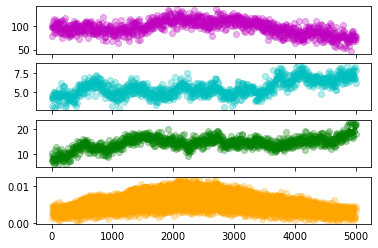

In [14]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(y_dict['t_x'], y_dict['x'][0, :], color = "m", label = 'SOC x')
axs[0].scatter(y_dict['t_y'], y_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs[1].plot(y_dict['t_x'], y_dict['x'][1, :], color = "c", label = 'DOC x')
axs[1].scatter(y_dict['t_y'], y_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs[2].plot(y_dict['t_x'], y_dict['x'][2, :], color = "g", label = 'MBC x')
axs[2].scatter(y_dict['t_y'], y_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs[3].plot(y_dict['t_x'], y_dict['x'][3, :], color = "orange", label = 'CO2')
axs[3].scatter(y_dict['t_y'], y_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [15]:
now = datetime.now()
sbm_model = 'SCON-SS_CO2_trunc_diff_theta' + now.strftime('_%Y_%m_%d_%H_%M')
dir_path = '../generated_data/'
save_string = dir_path + f'{sbm_model}_sample_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
save_string_x = dir_path + f'{sbm_model}_sample_x_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig.savefig(save_string + '.png', dpi = 300)

In [16]:
#Save CSV of stochastic path.
df_y = pd.DataFrame(data = {'hour': y_dict['t_y'], 'SOC': y_dict['y'][0, :], 'DOC': y_dict['y'][1, :], 'MBC': y_dict['y'][2, :], 'CO2': y_dict['y'][3, :]})
df_y.to_csv(save_string + '.csv', index = False)

In [17]:
#Save rsampled theta values.
torch.save(SCON_SS_params_dict, save_string + '_rsample.pt')

#Save priors dict.
torch.save(SCON_SS_priors_dict, save_string + '_hyperparams.pt')

In [18]:
print(df_y)

        hour         SOC       DOC        MBC       CO2
0        0.0   98.539502  4.142570   7.167774  0.002425
1        5.0   79.984544  4.567504   9.147490  0.004631
2       10.0   99.268428  4.140432   7.438065  0.003557
3       15.0  102.661648  3.190191  10.271492  0.001415
4       20.0   99.071232  3.945520   6.568321  0.002632
...      ...         ...       ...        ...       ...
996   4980.0   79.408589  6.855044  21.496026  0.002078
997   4985.0   67.564431  8.299222  21.136598  0.001428
998   4990.0   77.855952  6.673224  21.814342  0.001544
999   4995.0   78.621250  7.897848  21.797511  0.003634
1000  5000.0   72.576919  6.159917  18.082480  0.004429

[1001 rows x 5 columns]


In [19]:
print(np.max(df_y['SOC']))
print(np.max(df_y['DOC']))
print(np.max(df_y['MBC']))
print(np.max(df_y['CO2']))

138.81337920119503
8.485669903038646
22.757649480125774
0.011917100813848397


In [20]:
y_det_dict = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, x0_SCON, t, dt, SCON_SS_params_dict, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [76.83976538  3.50895323  7.91207844]


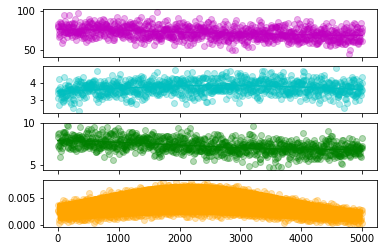

In [21]:
fig2, axs2 = plt.subplots(4, sharex = True)
axs2[0].plot(y_det_dict['t_x'], y_det_dict['x'][0, :], color = "m", label = 'SOC x')
axs2[0].scatter(y_det_dict['t_y'], y_det_dict['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs2[1].plot(y_det_dict['t_x'], y_det_dict['x'][1, :], color = "c", label = 'DOC x')
axs2[1].scatter(y_det_dict['t_y'], y_det_dict['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs2[2].plot(y_det_dict['t_x'], y_det_dict['x'][2, :], color = "g", label = 'MBC x')
axs2[2].scatter(y_det_dict['t_y'], y_det_dict['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs2[3].plot(y_det_dict['t_x'], y_det_dict['x'][3, :], color = "orange", label = 'CO2')
axs2[3].scatter(y_det_dict['t_y'], y_det_dict['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [22]:
SCON_SS_params_dict_test = {'u_M': 0.0001, 'a_SD': 0.5, 'a_DS': 0.5, 'a_M': 0.5, 'a_MSC': 0.5, 'k_S_ref': 0.000027333, 'k_D_ref': 0.0003167, 'k_M_ref': 0.00004, 'Ea_S': 50, 'Ea_D': 45, 'Ea_M': 45, 's_SOC': s_SOC, 's_DOC': s_DOC, 's_MBC': s_MBC}

In [23]:
y_det_dict_test = get_SBM_SDE_euler_maruyama_y_det(alpha_SCON, [2 * 50, 2 * 2, 2 * 5], t, dt, SCON_SS_params_dict_test, I_S_func, I_D_func, temp_func, temp_ref, temp_rise, obs_every, obs_error_scale)

X0_sample =  [94.87303211  4.62356121  9.74997572]


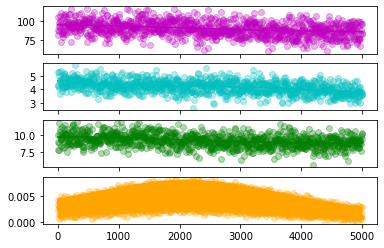

In [24]:
fig3, axs3 = plt.subplots(4, sharex = True)
axs3[0].plot(y_det_dict_test['t_x'], y_det_dict_test['x'][0, :], color = "m", label = 'SOC x')
axs3[0].scatter(y_det_dict_test['t_y'], y_det_dict_test['y'][0, :], color = "m", alpha = 0.3, label = 'SOC y')
axs3[1].plot(y_det_dict_test['t_x'], y_det_dict_test['x'][1, :], color = "c", label = 'DOC x')
axs3[1].scatter(y_det_dict_test['t_y'], y_det_dict_test['y'][1, :], color = "c", alpha = 0.3, label = 'DOC y')
axs3[2].plot(y_det_dict_test['t_x'], y_det_dict_test['x'][2, :], color = "g", label = 'MBC x')
axs3[2].scatter(y_det_dict_test['t_y'], y_det_dict_test['y'][2, :], color = "g", alpha = 0.3, label = 'MBC y')
axs3[3].plot(y_det_dict_test['t_x'], y_det_dict_test['x'][3, :], color = "orange", label = 'CO2')
axs3[3].scatter(y_det_dict_test['t_y'], y_det_dict_test['y'][3, :], color = "orange", alpha = 0.3, label = 'CO2 y')

In [25]:
save_string_det = dir_path + f'{sbm_model}_sample_det_y_t_{t}_dt_{dt}_sd_scale_{prior_scale_factor}'.replace('.','-')
fig2.savefig(save_string_det + '.png', dpi = 300)

In [ ]:
df_y_det = pd.DataFrame(data = {'hour': y_det_dict['t_y'], 'SOC': y_det_dict['y'][0, :], 'DOC': y_det_dict['y'][1, :], 'MBC': y_det_dict['y'][2, :], 'CO2': y_det_dict['y'][3, :]})
df_y_det.to_csv(save_string_det + '.csv', index = False)

In [ ]:
print(df_y_det)